In [1]:
# ==============================================================================
# SEL 1: Inisialisasi Library dan Penyiapan Seed
# ==============================================================================

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import tensorflow as tf
import random
import os

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K


# Menetapkan seed untuk reproduktifitas hasil
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)
os.environ['PYTHONHASHSEED'] = '42'
# Untuk memastikan hasil tetap sama saat dijalankan ulang
tf.config.experimental.enable_op_determinism()


In [35]:
# ==============================================================================
# SEL 2: Memuat Data Saham
# ==============================================================================

# Nama file CSV data saham
stock_file_name = "BBCA.csv"
# Membaca CSV
df = pd.read_csv("BBCA.csv")  # Menyesuaikan delimiter


# menghapus kolom yang semua isinya NaN
df = df.dropna(axis='columns', how='all')
# Menampilkan hasil
print(df)  # Cek apakah kolom sudah benar

# Konversi kolom 'Date' menjadi format datetime
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df.set_index('Date', inplace=True)


            Date  Close
0       2/1/2020   6690
1       3/1/2020   6800
2       6/1/2020   6735
3       7/1/2020   6740
4       8/1/2020   6680
...          ...    ...
1167  25/10/2024  10750
1168  28/10/2024  10600
1169  29/10/2024  10500
1170  30/10/2024  10350
1171  31/10/2024  10250

[1172 rows x 2 columns]


In [36]:
# ==============================================================================
# SEL 3: Memeriksa Nilai Null
# ==============================================================================

# Memeriksa data untuk nilai null
print("\nCek Nilai Null:")
print(df.isnull().sum())

if df.isnull().sum().any():
    print("\nWarning: Terdapat nilai null.")
else:
    print("\nTidak ada nilai null ditemukan.")




Cek Nilai Null:
Close    0
dtype: int64

Tidak ada nilai null ditemukan.


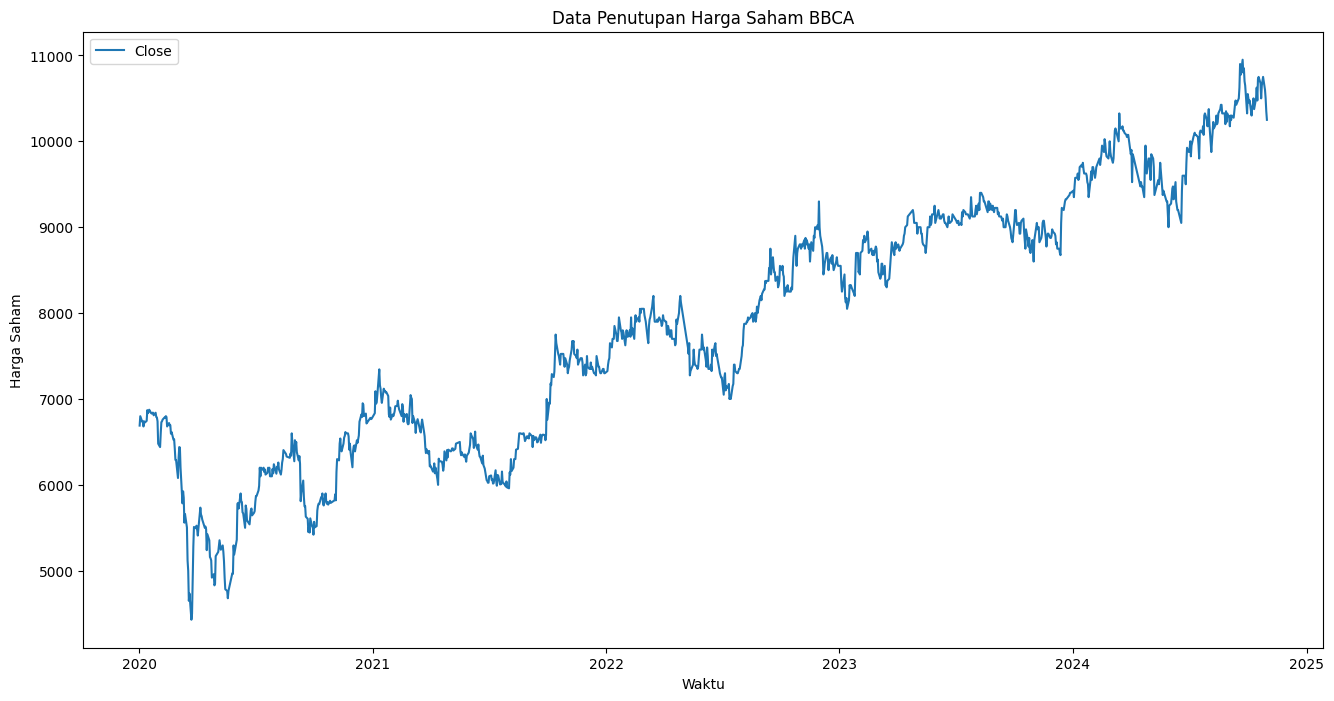


Grafik historis harga saham BBCA telah ditampilkan.


In [4]:
# ==============================================================================
# SEL 4: Visualisasi Data Historis
# ==============================================================================

# Ekstrak nama saham dari nama file untuk judul grafik
stock_name = stock_file_name.replace(".csv", "").upper()
# Visualisasi data historis
plt.figure(figsize=(16, 8))
plt.plot(df['Close'], label='Close')
plt.title(f'Data Penutupan Harga Saham {stock_name}')
plt.xlabel('Waktu')
plt.ylabel('Harga Saham')
plt.legend()
plt.show()

print(f"\nGrafik historis harga saham {stock_name} telah ditampilkan.")

In [5]:
# ==============================================================================
# SEL 5: Normalisasi Data
# ==============================================================================

# Menormalisasi data dengan MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(df[['Close']].values)
print("\nData Normalisasi:")
print(data_scaled)
print(f"Nilai terendah data asli (Xmin): {scaler.data_min_[0]:.2f}")
print(f"Nilai tertinggi data asli (Xmax): {scaler.data_max_[0]:.2f}")


Data Normalisasi:
[[0.34662577]
 [0.36349693]
 [0.35352761]
 ...
 [0.9309816 ]
 [0.90797546]
 [0.89263804]]
Nilai terendah data asli (Xmin): 4430.00
Nilai tertinggi data asli (Xmax): 10950.00


In [6]:
# ==============================================================================
# SEL 6: Pembagian Data Latih dan Uji
# ==============================================================================

# Membagi data menjadi latih dan uji
training_size = int(len(data_scaled) * 0.8)
train_data, test_data = data_scaled[:training_size], data_scaled[training_size:]
print("Ukuran data training: ", train_data.shape)
print("Ukuran data testing : ", test_data.shape)

Ukuran data training:  (937, 1)
Ukuran data testing :  (235, 1)


In [7]:
# ==============================================================================
# SEL 7: Pembuatan Dataset Time-Series
# ==============================================================================

# Fungsi untuk membuat dataset time-series
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step):
        dataX.append(dataset[i:(i + time_step), 0]) # Ambil time_step data sebagai input
        dataY.append(dataset[i + time_step, 0]) # Data berikutnya sebagai prediksi
    return np.array(dataX), np.array(dataY)

# Definisikan time step
time_step = 60
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("Shape X_train:", X_train.shape)
print("Shape X_test:", X_test.shape)
print("Shape y_train:", y_train.shape)
print("Shape y_test:", y_test.shape)

Shape X_train: (877, 60)
Shape X_test: (175, 60)
Shape y_train: (877,)
Shape y_test: (175,)


In [8]:
# ==============================================================================
# SEL 8: Reshape Input untuk LSTM
# ==============================================================================

# Mengubah bentuk input untuk LSTM: (sampel, time_step, fitur)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print("Shape X_train:", X_train.shape)
print("Shape X_test:", X_test.shape)

Shape X_train: (877, 60, 1)
Shape X_test: (175, 60, 1)


In [9]:
# ==============================================================================
# SEL 9: Membangun dan Melatih Model LSTM
# ==============================================================================

# Membuat Model LSTM
n_neurons = 50
epochs = 200
batch_size = 16

model = Sequential([
    LSTM(n_neurons, activation='tanh', recurrent_activation="sigmoid", input_shape=(time_step, 1)),
    Dense(1) # Menggunakan sigmoid untuk output layer
])

# Mengkompilasi model (Optimizer Adam, Loss MSE)
model.compile(optimizer='adam', loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Melatih model
print(f"\nMemulai pelatihan model LSTM (Epochs={epochs}, Batch Size={batch_size})...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stopping],
    verbose=1
)
print("\nPelatihan selesai.")


Memulai pelatihan model LSTM (Epochs=200, Batch Size=16)...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 8s 70ms/step - loss: 0.0805 - val_loss: 0.0084
Epoch 2/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 3/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 4/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 9.6993e-04 - val_loss: 0.0010
Epoch 5/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 9.4497e-04 - val_loss: 0.0010
Epoch 6/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 9.1921e-04 - val_loss: 9.8483e-04
Epoch 7/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 8.9591e-04 - val_loss: 9.6191e-04
Epoch 8/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 8.7456e-04 - val_loss: 9.4044e-04
Epoch 9/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 8.5430e-04 - val_loss: 9.2087e-04
Epoch 10/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 8.3481e-04 - val_loss: 9.0334e-04
Epoch 11/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 8.1589e-04 - val_loss: 8.8809e

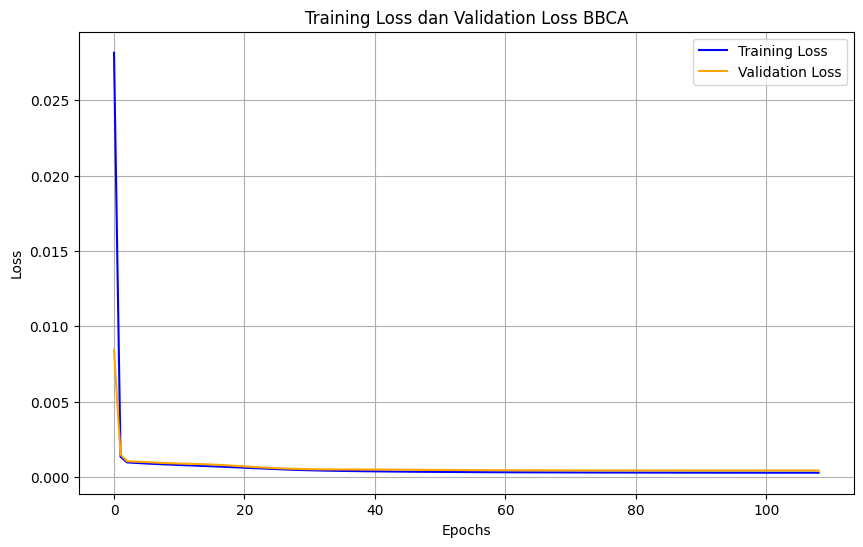


Grafik Training Loss dan Validation Loss telah ditampilkan.


In [10]:
# ==============================================================================
# SEL 10: Visualisasi Training Loss dan Validation Loss
# ==============================================================================

# Visualisasi Training Loss dan Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title(f'Training Loss dan Validation Loss {stock_name}')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

print("\nGrafik Training Loss dan Validation Loss telah ditampilkan.")

In [11]:
# ==============================================================================
# SEL 11: Ekstraksi Bobot dan Bias Awal LSTM
# Untuk menyimpan bobot awal model yang dilatih Keras
# ==============================================================================

#  Ambil Bobot Awal dari layer LSTM dan Dense
lstm_weights = model.layers[0].get_weights()
W, U, b = lstm_weights[0], lstm_weights[1], lstm_weights[2]

dense_weights = model.layers[1].get_weights()
Wd, bd = dense_weights[0], dense_weights[1]

# Pecah Bobot LSTM ke Setiap Gate (sesuai urutan di skripsi: f, i, c, o)

def split_weights(W, U, b):
    W_i, W_f, W_c, W_o = np.split(W, 4, axis=1)  # kernel weights
    U_i, U_f, U_c, U_o = np.split(U, 4, axis=1)  # recurrent weights
    b_i, b_f, b_c, b_o = np.split(b, 4)  # biases
    return (W_i, U_i, b_i), (W_f, U_f, b_f), (W_c, U_c, b_c), (W_o, U_o, b_o)

(Wi, Ui, bi), (Wf, Uf, bf), (Wc, Uc, bc), (Wo, Uo, bo) = split_weights(W, U, b)

# Keras menyimpan dalam urutan (i, f, c, o)
target_file = "LSTM_Weights.xlsx"
with pd.ExcelWriter(target_file) as writer:
    pd.DataFrame(Wi).to_excel(writer, sheet_name="Wi")
    pd.DataFrame(Ui).to_excel(writer, sheet_name="Ui")
    pd.DataFrame(bi).to_excel(writer, sheet_name="bi")

    pd.DataFrame(Wf).to_excel(writer, sheet_name="Wf")
    pd.DataFrame(Uf).to_excel(writer, sheet_name="Uf")
    pd.DataFrame(bf).to_excel(writer, sheet_name="bf")

    pd.DataFrame(Wc).to_excel(writer, sheet_name="Wc")
    pd.DataFrame(Uc).to_excel(writer, sheet_name="Uc")
    pd.DataFrame(bc).to_excel(writer, sheet_name="bc")

    pd.DataFrame(Wo).to_excel(writer, sheet_name="Wo")
    pd.DataFrame(Uo).to_excel(writer, sheet_name="Uo")
    pd.DataFrame(bo).to_excel(writer, sheet_name="bo")

print(f"\n== File {target_file} telah disimpan! ==")



== File LSTM_Weights.xlsx telah disimpan! ==


In [12]:
# ==============================================================================
# SEL 12: Simulasi Perhitungan Manual Forward Pass Pada Batch Pertama
# ==============================================================================

# Fungsi Sigmoid dan Tanh untuk Perhitungan Manual
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def tanh(x):
    return np.tanh(x)

# Hitung Forward Pass

def lstm_forward(X, Wi, Ui, bi, Wf, Uf, bf, Wo, Uo, bo, Wc, Uc, bc):
    batch_size, time_steps, input_dim = X.shape
    hidden_dim = Ui.shape[0]  # Jumlah unit LSTM

    h_t = np.zeros((batch_size, hidden_dim))  # Hidden state awal
    c_t = np.zeros((batch_size, hidden_dim))  # Cell state awal

    for t in range(time_steps):
        x_t = X[:, t, :]  # Ambil input per time step

        # Hitung setiap gate
        i_t = sigmoid(np.dot(x_t, Wi) + np.dot(h_t, Ui) + bi)  # Input gate
        f_t = sigmoid(np.dot(x_t, Wf) + np.dot(h_t, Uf) + bf)  # Forget gate
        o_t = sigmoid(np.dot(x_t, Wo) + np.dot(h_t, Uo) + bo)  # Output gate
        c_tilde = tanh(np.dot(x_t, Wc) + np.dot(h_t, Uc) + bc)  # Candidate cell state

        # Update cell state dan hidden state
        c_t = f_t * c_t + i_t * c_tilde
        h_t = o_t * tanh(c_t)

    return i_t, f_t, o_t, c_tilde, h_t, c_t

# Ambil batch pertama
batch_sample = X_train[:16]

# Hitung forward pass
i_t, f_t, o_t, c_tilde, h_t, c_t = lstm_forward(
    batch_sample, Wi, Ui, bi, Wf, Uf, bf, Wo, Uo, bo, Wc, Uc, bc
)

# Hitung Output dari Dense Layer
dense_weights = model.layers[1].get_weights()
Wd, bd = dense_weights[0], dense_weights[1]
dense_output = np.dot(h_t, Wd) + bd

# Simpan Hasil Forward Pass ke dalam Excel
target_file = "LSTM_Forward_Pass.xlsx"
with pd.ExcelWriter(target_file) as writer:
    pd.DataFrame(i_t).to_excel(writer, sheet_name="Input_Gate")
    pd.DataFrame(f_t).to_excel(writer, sheet_name="Forget_Gate")
    pd.DataFrame(o_t).to_excel(writer, sheet_name="Output_Gate")
    pd.DataFrame(c_tilde).to_excel(writer, sheet_name="Cell_Candidate")
    pd.DataFrame(h_t).to_excel(writer, sheet_name="Hidden_State")
    pd.DataFrame(c_t).to_excel(writer, sheet_name="Cell_State")
    pd.DataFrame(dense_output).to_excel(writer, sheet_name="Dense_Output")

print(f"\n== File {target_file} telah disimpan! ==")



== File LSTM_Forward_Pass.xlsx telah disimpan! ==


In [13]:
# ==============================================================================
# SEL 13: Simulasi Perhitungan Manual Gradien (Backpropagation)
# ==============================================================================

# Cek apakah model sudah dilatih
assert 'model' in globals(), "Model belum dilatih! Jalankan pelatihan terlebih dahulu."

# Definisikan fungsi loss
loss_fn = tf.keras.losses.MeanSquaredError()

# Gunakan GradientTape untuk menghitung gradien
def compute_gradients(model, X_batch, y_batch):
    with tf.GradientTape() as tape:
        predictions = model(X_batch, training=True)
        loss = loss_fn(y_batch, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    return gradients

# Ambil batch pertama untuk perhitungan gradien
X_batch, y_batch = X_train[:16], y_train[:16]
gradients = compute_gradients(model, X_batch, y_batch)

# 4. Pecah gradien ke setiap gate
W_grad, U_grad, b_grad = gradients[0].numpy(), gradients[1].numpy(), gradients[2].numpy()

def split_gradients(W, U, b):
    dWi, dWf, dWc, dWo = np.split(W, 4, axis=1)
    dUi, dUf, dUc, dUo = np.split(U, 4, axis=1)
    dbi, dbf, dbc, dbo = np.split(b, 4)
    return (dWi, dUi, dbi), (dWf, dUf, dbf), (dWc, dUc, dbc), (dWo, dUo, dbo)

(dWi, dUi, dbi), (dWf, dUf, dbf), (dWc, dUc, dbc), (dWo, dUo, dbo) = split_gradients(W_grad, U_grad, b_grad)

# 5. Simpan hasil gradien ke dalam file Excel
file_name = "LSTM_Gradients.xlsx"
with pd.ExcelWriter(file_name) as writer:
    pd.DataFrame(dWi).to_excel(writer, sheet_name="dWi")
    pd.DataFrame(dUi).to_excel(writer, sheet_name="dUi")
    pd.DataFrame(dbi).to_excel(writer, sheet_name="dbi")

    pd.DataFrame(dWf).to_excel(writer, sheet_name="dWf")
    pd.DataFrame(dUf).to_excel(writer, sheet_name="dUf")
    pd.DataFrame(dbf).to_excel(writer, sheet_name="dbf")

    pd.DataFrame(dWc).to_excel(writer, sheet_name="dWc")
    pd.DataFrame(dUc).to_excel(writer, sheet_name="dUc")
    pd.DataFrame(dbc).to_excel(writer, sheet_name="dbc")

    pd.DataFrame(dWo).to_excel(writer, sheet_name="dWo")
    pd.DataFrame(dUo).to_excel(writer, sheet_name="dUo")
    pd.DataFrame(dbo).to_excel(writer, sheet_name="dbo")

print(f"\n== File {file_name} telah disimpan! ==")



== File LSTM_Gradients.xlsx telah disimpan! ==


In [14]:
# ==============================================================================
# SEL 14: Simulasi Perhitungan Manual Update Bobot Adam
# ==============================================================================

# Adam Optimizer Parameters
learning_rate = 0.001
beta1 = 0.9
beta2 = 0.999
epsilon = 1e-8

# Inisialisasi m dan v untuk Adam
m_W, v_W = np.zeros_like(W), np.zeros_like(W)
m_U, v_U = np.zeros_like(U), np.zeros_like(U)
m_b, v_b = np.zeros_like(b), np.zeros_like(b)

t = 1  # Iterasi pertama Adam

def adam_update(param, grad, m, v, t, lr=learning_rate, beta1=beta1, beta2=beta2, eps=epsilon):
    """Fungsi untuk memperbarui parameter menggunakan Adam optimizer"""
    m = beta1 * m + (1 - beta1) * grad
    v = beta2 * v + (1 - beta2) * (grad ** 2)
    m_hat = m / (1 - beta1 ** t)
    v_hat = v / (1 - beta2 ** t)
    param -= lr * m_hat / (np.sqrt(v_hat) + eps)
    return param, m, v

# Update bobot dan bias untuk setiap gate
W_new, m_W, v_W = adam_update(W, W_grad, m_W, v_W, t)
U_new, m_U, v_U = adam_update(U, U_grad, m_U, v_U, t)
b_new, m_b, v_b = adam_update(b, b_grad, m_b, v_b, t)

# Pecah bobot baru ke dalam setiap gate
(Wi_new, Ui_new, bi_new), (Wf_new, Uf_new, bf_new), (Wc_new, Uc_new, bc_new), (Wo_new, Uo_new, bo_new) = split_weights(W_new, U_new, b_new)

# Simpan bobot baru ke dalam file Excel
updated_weights_file = "LSTM_Updated_Weights.xlsx"
with pd.ExcelWriter(updated_weights_file) as writer:
    pd.DataFrame(Wi_new).to_excel(writer, sheet_name="Wi_New")
    pd.DataFrame(Ui_new).to_excel(writer, sheet_name="Ui_New")
    pd.DataFrame(bi_new).to_excel(writer, sheet_name="bi_New")

    pd.DataFrame(Wf_new).to_excel(writer, sheet_name="Wf_New")
    pd.DataFrame(Uf_new).to_excel(writer, sheet_name="Uf_New")
    pd.DataFrame(bf_new).to_excel(writer, sheet_name="bf_New")

    pd.DataFrame(Wc_new).to_excel(writer, sheet_name="Wc_New")
    pd.DataFrame(Uc_new).to_excel(writer, sheet_name="Uc_New")
    pd.DataFrame(bc_new).to_excel(writer, sheet_name="bc_New")

    pd.DataFrame(Wo_new).to_excel(writer, sheet_name="Wo_New")
    pd.DataFrame(Uo_new).to_excel(writer, sheet_name="Uo_New")
    pd.DataFrame(bo_new).to_excel(writer, sheet_name="bo_New")

print(f"\n== Bobot dan bias baru telah disimpan di {updated_weights_file}! ==")



== Bobot dan bias baru telah disimpan di LSTM_Updated_Weights.xlsx! ==


In [15]:
# ==============================================================================
# SEL 15: Evaluasi Model dengan MAPE
# ==============================================================================

# 3. Evaluasi Model
# Membuat prediksi
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Mengembalikan data ke skala aslinya
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train_original = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

# Menghitung metrik evaluasi untuk data latih dan uji
train_mape = np.mean(np.abs((y_train_original - train_predict) / y_train_original)) * 100
test_mape = np.mean(np.abs((y_test_original - test_predict) / y_test_original)) * 100

print("\nEvaluasi Model:")
print(f"Train MAPE: {train_mape}%")
print(f"Test MAPE: {test_mape}%")

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

Evaluasi Model:
Train MAPE: 1.1191593300519185%
Test MAPE: 1.0606108486359882%


In [16]:
# Mengambil bobot dari layer LSTM
lstm_layer = model.layers[0]  # Lapisan LSTM
weights = lstm_layer.get_weights()


# Memisahkan bobot menjadi Kernel (W), Recurrent weights (U), dan Bias (b)
W = weights[0]  # Kernel weights (input to gates)
U = weights[1]  # Recurrent weights (hidden state to gates)
b = weights[2]  # Bias

# Menampilkan ukuran setiap bobot
print("Shape of W (bobot input):", W.shape)
print("Shape of U (Bobot hidden state):", U.shape)
print("Shape of b (Bias):", b.shape)

# Memisahkan bobot untuk setiap gate
units = lstm_layer.units  # Jumlah unit (neurons) dalam LSTM

W_f, W_i, W_c, W_o = W[:, :units], W[:, units:2*units], W[:, 2*units:3*units], W[:, 3*units:]
U_f, U_i, U_c, U_o = U[:, :units], U[:, units:2*units], U[:, 2*units:3*units], U[:, 3*units:]
b_f, b_i, b_c, b_o = b[:units], b[units:2*units], b[2*units:3*units], b[3*units:]


Shape of W (bobot input): (1, 200)
Shape of U (Bobot hidden state): (50, 200)
Shape of b (Bias): (200,)


In [17]:
# Menampilkan bobot untuk Forget Gate
print("W_f (Bobot Input untuk Forget Gate):\n", W_f)
print("U_f (Bobot hidden state untuk Forget Gate):\n", U_f)
print("b_f (Bias untuk Forget Gate):\n", b_f)

print("Shape of W_f:", W_f.shape)
print("Shape of U_f:", U_f.shape)
print("Shape of b_f:", b_f.shape)

W_f (Bobot Input untuk Forget Gate):
 [[ 0.1948957   0.13266835 -0.0705236   0.1345127  -0.24865763  0.0909341
   0.11773778 -0.14732756  0.01376943  0.0335062  -0.06702632  0.03115155
   0.18764511 -0.00137824  0.01383523  0.19125243 -0.18888953 -0.11004981
  -0.01031015  0.98709995 -0.11847158  0.1816883   0.12169425  0.02819776
   0.19365916 -0.09872989  0.04725212  0.091842    0.11265404 -0.07315923
  -0.06534708  0.19477148 -0.10820102  0.01524277 -0.12292583 -0.19038677
   0.14238772 -0.07585181  0.10361242  0.04724003 -0.17294522  0.2103989
  -0.02746224  0.04841968  0.19063471  0.03398344  0.03675785 -0.11921244
  -0.06696276  0.1648688 ]]
U_f (Bobot hidden state untuk Forget Gate):
 [[ 0.03823622 -0.02704702  0.05008245 ... -0.03675408 -0.07830003
  -0.00497605]
 [ 0.03293815  0.02902778 -0.02543691 ... -0.15055315  0.0077528
   0.17392439]
 [-0.06223234 -0.02161819  0.02119536 ... -0.01406743 -0.06270377
  -0.0243283 ]
 ...
 [ 0.0328791  -0.0199544   0.04053328 ...  0.1339033

In [18]:
# Menampilkan bobot untuk Input Gate
print("W_i (Bobot Input untuk Input Gate):\n", W_i)
print("U_i (Bobot hidden state untuk Input Gate):\n", U_i)
print("b_i (Bias untuk Input Gate):\n", b_i)
print("Shape of W_i:", W_i.shape)
print("Shape of U_i:", U_i.shape)
print("Shape of b_i:", b_i.shape)

W_i (Bobot Input untuk Input Gate):
 [[ 0.07223023  0.04607249 -0.19155182 -0.13847288  0.03747282  0.13734825
  -0.04751091 -0.09129465 -0.15150517 -0.16870901  0.09157933  0.14529525
  -0.0216785   0.0831994  -0.05398367  0.12262442 -0.0781244  -0.04487528
   0.11711868 -0.5068064   0.09446584  0.1694365   0.11971623 -0.03382363
   0.1279096  -0.13345884  0.19989617  0.11496339  0.07312731 -0.09578894
  -0.07982675  0.18102957 -0.13101181 -0.0331526  -0.12651666 -0.15856545
   0.16395344  0.14198868  0.06763599  0.00702478  0.00371059  0.17665683
   0.0111963  -0.08321928  0.13556036  0.00243934  0.11858384  0.10107194
   0.01709773 -0.12500246]]
U_i (Bobot hidden state untuk Input Gate):
 [[ 0.05252793  0.08149904 -0.15560424 ... -0.02272713  0.03865157
  -0.08515154]
 [-0.11777448  0.00789867  0.01146646 ... -0.19244148 -0.01051331
   0.13734774]
 [-0.11483511  0.05762642  0.00275006 ... -0.03556306 -0.06727051
   0.06667629]
 ...
 [ 0.08704245  0.1501643  -0.04254181 ... -0.063351

In [19]:
# Menampilkan bobot untuk Cell State
print("W_c (Bobot Input untuk Cell State):\n", W_c)
print("U_c (Bobot hidden state untuk Cell State):\n", U_c)
print("b_c (Bias untuk Cell State):\n", b_c)
print("Shape of W_c:", W_c.shape)
print("Shape of U_c:", U_c.shape)
print("Shape of b_c:", b_c.shape)

W_c (Bobot Input untuk Cell State):
 [[ 0.22071823  0.19249488  0.02950767 -0.07786924 -0.05758688  0.12764254
  -0.08111908  0.02341128  0.07958666  0.03306604 -0.160849    0.12183835
  -0.064592    0.13702695  0.01885581 -0.13740042  0.10731719 -0.16102648
  -0.0721694  -0.7464607   0.0422415  -0.2031175  -0.09934185  0.23105252
   0.05642776 -0.12768197  0.1817444  -0.19390836  0.10597821 -0.13893878
   0.13785605 -0.10713282 -0.02175524 -0.03873472 -0.02779429 -0.0873386
  -0.05026769  0.00784528  0.19861329 -0.09518745 -0.12645102 -0.22360288
   0.06457417  0.18576661  0.15812491  0.08418031 -0.04140859  0.12811433
   0.00514324 -0.13421825]]
U_c (Bobot hidden state untuk Cell State):
 [[-0.17243282  0.01666217  0.01373452 ... -0.0471883   0.1055328
   0.01706901]
 [-0.02746553 -0.00034505  0.13518538 ...  0.05754807 -0.06468175
  -0.00881836]
 [ 0.01451958  0.07198563 -0.09086045 ...  0.03099279  0.0560145
   0.00468679]
 ...
 [ 0.14473009 -0.05366883  0.10833284 ...  0.02852885 

In [20]:
# Menampilkan bobot untuk Output Gate
print("W_o (Bobot Input untuk Output Gate):\n", W_o)
print("U_o (Bobot hidden state untuk Output Gate):\n", U_o)
print("b_o (Bias untuk Output Gate):\n", b_o)
print("Shape of W_o:", W_o.shape)
print("Shape of U_o:", U_o.shape)
print("Shape of b_o:", b_o.shape)

W_o (Bobot Input untuk Output Gate):
 [[ 1.25717938e-01  2.96301097e-01 -1.69001624e-01 -3.17667946e-02
  -2.28754103e-01 -1.24034151e-01  6.02606274e-02 -1.18652515e-01
   1.65954307e-01  1.49062574e-01  1.58829674e-01  1.23295054e-01
  -8.78748447e-02  1.40731722e-01  1.89927712e-01  1.88647434e-02
   1.00720279e-01 -7.53368214e-02  1.14635915e-01  6.42528415e-01
  -2.47947243e-03  1.26682758e-01 -1.63854677e-02  1.67158902e-01
   1.47251382e-01  2.13203996e-01  1.01861775e-01  1.87738575e-02
   2.55225182e-01 -1.30392075e-01  3.51954848e-02  2.13194430e-01
  -9.58433151e-02 -1.59729607e-02 -1.29949570e-01 -1.19012475e-01
   1.36289671e-01 -4.40617986e-02 -4.97047440e-04 -6.79403096e-02
   1.39502005e-03  2.04076022e-01  4.99311686e-02  2.18999684e-01
   2.40654498e-01  2.69847751e-01  2.32668258e-02 -3.51977125e-02
   2.55305231e-01  1.66516557e-01]]
U_o (Bobot hidden state untuk Output Gate):
 [[ 0.01697559  0.12420999  0.11741414 ... -0.07313977 -0.06535637
   0.08369786]
 [ 0.086

In [21]:
# Menyimpan semua bobot dan bias ke dalam satu file Excel
with pd.ExcelWriter("LSTM_Weights_Biases.xlsx", engine="openpyxl") as writer:
    pd.DataFrame(W_f).to_excel(writer, sheet_name="W_f (Forget Gate)", index=False)
    pd.DataFrame(W_i).to_excel(writer, sheet_name="W_i (Input Gate)", index=False)
    pd.DataFrame(W_c).to_excel(writer, sheet_name="W_c (Candidate Gate)", index=False)
    pd.DataFrame(W_o).to_excel(writer, sheet_name="W_o (Output Gate)", index=False)

    pd.DataFrame(U_f).to_excel(writer, sheet_name="U_f (Forget Gate)", index=False)
    pd.DataFrame(U_i).to_excel(writer, sheet_name="U_i (Input Gate)", index=False)
    pd.DataFrame(U_c).to_excel(writer, sheet_name="U_c (Candidate Gate)", index=False)
    pd.DataFrame(U_o).to_excel(writer, sheet_name="U_o (Output Gate)", index=False)

    pd.DataFrame(b_f).to_excel(writer, sheet_name="b_f (Forget Gate)", index=False)
    pd.DataFrame(b_i).to_excel(writer, sheet_name="b_i (Input Gate)", index=False)
    pd.DataFrame(b_c).to_excel(writer, sheet_name="b_c (Candidate Gate)", index=False)
    pd.DataFrame(b_o).to_excel(writer, sheet_name="b_o (Output Gate)", index=False)

print("Semua bobot dan bias berhasil disimpan dalam satu file Excel!")

Semua bobot dan bias berhasil disimpan dalam satu file Excel!


In [22]:
# === Ambil Bobot & Bias Dense Layer ===
dense_weights, dense_bias = model.layers[1].get_weights()

print("W_dense: ", dense_weights)
print("b_dense: ", dense_bias)

W_dense:  [[ 0.2837837 ]
 [ 0.14854714]
 [ 0.02412293]
 [ 0.06592318]
 [ 0.15172778]
 [ 0.20725375]
 [ 0.19985348]
 [ 0.25296563]
 [-0.14954205]
 [ 0.11832791]
 [-0.32783663]
 [ 0.18993917]
 [-0.10173937]
 [-0.03899656]
 [ 0.00995284]
 [-0.3770899 ]
 [-0.1261219 ]
 [-0.07507455]
 [ 0.21134222]
 [-0.71587265]
 [ 0.05858063]
 [-0.10687092]
 [ 0.25590906]
 [ 0.29045165]
 [-0.24090399]
 [-0.10256617]
 [ 0.339691  ]
 [-0.36262614]
 [ 0.38574994]
 [-0.05291223]
 [ 0.24163556]
 [-0.06367006]
 [-0.23571022]
 [-0.22285774]
 [ 0.21101837]
 [ 0.23151192]
 [-0.2492409 ]
 [-0.07136448]
 [ 0.33723757]
 [-0.01334593]
 [ 0.01777555]
 [-0.22528139]
 [ 0.14739332]
 [ 0.25703907]
 [ 0.09670001]
 [ 0.29852155]
 [-0.27943844]
 [-0.23702502]
 [ 0.17005517]
 [-0.24858458]]
b_dense:  [0.01211482]


In [23]:
# ==============================================================================
# Training Data
# ==============================================================================

# === Fungsi aktivasi ===
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def tanh(x):
    return np.tanh(x)

# === Gunakan X_test asli ===
print("Shape X_test:", X_test.shape)  # Pastikan ukurannya (175, 90, 1)

# === Inisialisasi hidden state & cell state ===
h_t = np.zeros((175, 50))
C_t = np.zeros((175, 50))

# === Forward Pass X_test Asli ===
for t in range(60):  # Looping tiap timestep
    x_t = X_test[:, t, :]  # Ambil input di timestep t → (175, 1)

    # Forget gate
    f_t = sigmoid(np.dot(x_t, W_f) + np.dot(h_t, U_f) + b_f.T)  # (175, 50)

    # Input gate
    i_t = sigmoid(np.dot(x_t, W_i) + np.dot(h_t, U_i) + b_i.T)  # (175, 50)

    # Candidate cell state
    C_tilde_t = tanh(np.dot(x_t, W_c) + np.dot(h_t, U_c) + b_c.T)  # (175, 50)

    # Cell state update
    C_t = f_t * C_t + i_t * C_tilde_t  # (175, 50)

    # Output gate
    o_t = sigmoid(np.dot(x_t, W_o) + np.dot(h_t, U_o) + b_o.T)  # (175, 50)

    # Hidden state update
    h_t = o_t * tanh(C_t)  # (175, 50)

    # === Hitung Output Dense Layer ===
    y_pred = np.dot(h_t, dense_weights) + dense_bias  # (175, 1)



# === Print hasil akhir ===
print("Forget Gate (f_t):", f_t)
print("Input Gate (i_t):", i_t)
print("Candidate Cell State (C_tilde_t):", C_tilde_t)
print("Cell State (C_t):", C_t)
print("Output Gate (o_t):", o_t)
print("Hidden State (h_t):", h_t)
print("\nOutput Dense Layer (y_pred):", y_pred)

print("\nUkuran Forget Gate (f_t):", f_t.shape)
print("Ukuran Input Gate (i_t):", i_t.shape)
print("Ukuran Candidate Cell State (C_tilde_t):", C_tilde_t.shape)
print("Ukuran Cell State (C_t):", C_t.shape)
print("Ukuran Output Gate (o_t):", o_t.shape)
print("Ukuran Hidden State (h_t):", h_t.shape)  # (175, 50)
print("Ukuran Output Dense Layer (y_pred):", y_pred.shape)  # (175, 1)


Shape X_test: (175, 60, 1)
Forget Gate (f_t): [[0.588826   0.52699132 0.48769875 ... 0.43672642 0.46149375 0.57589274]
 [0.58931949 0.52696789 0.48766397 ... 0.43626034 0.46127763 0.57631087]
 [0.58870393 0.52623435 0.48800793 ... 0.43654076 0.46139722 0.5757539 ]
 ...
 [0.60264029 0.52711567 0.48736545 ... 0.4271091  0.4518866  0.58536624]
 [0.60167791 0.52646568 0.4877052  ... 0.42782686 0.45210716 0.58446904]
 [0.60009149 0.52563516 0.48821727 ... 0.42909556 0.45260197 0.58300681]]
Input Gate (i_t): [[0.7397672  0.71759625 0.68830869 ... 0.72215682 0.71443289 0.71107766]
 [0.73968625 0.71735784 0.6880862  ... 0.72188096 0.71429154 0.71113139]
 [0.73935389 0.71696966 0.688805   ... 0.72131656 0.71404665 0.71160674]
 ...
 [0.74063828 0.71350336 0.68262702 ... 0.72007692 0.70948078 0.70906214]
 [0.74045187 0.7133822  0.68354613 ... 0.71990154 0.70932553 0.70939584]
 [0.74021611 0.7133917  0.68492622 ... 0.71973831 0.70924192 0.70998594]]
Candidate Cell State (C_tilde_t): [[ 0.08750568 

In [24]:
# === Simpan hasil ke dalam Excel ===
file_path = "hasil_forward_pass.xlsx"
with pd.ExcelWriter(file_path) as writer:
    pd.DataFrame(f_t).to_excel(writer, sheet_name="Forget Gate")
    pd.DataFrame(i_t).to_excel(writer, sheet_name="Input Gate")
    pd.DataFrame(C_tilde_t).to_excel(writer, sheet_name="Candidate Cell State")
    pd.DataFrame(C_t).to_excel(writer, sheet_name="Cell State")
    pd.DataFrame(o_t).to_excel(writer, sheet_name="Output Gate")
    pd.DataFrame(h_t).to_excel(writer, sheet_name="Hidden State")
    pd.DataFrame(y_pred).to_excel(writer, sheet_name="Dense layer")

print(f"\n✅ Hasil forward pass telah disimpan di: {file_path}")


✅ Hasil forward pass telah disimpan di: hasil_forward_pass.xlsx


In [25]:
# ==============================================================================
# Akurasi Data Train, Test, dan Keseluruhan
# ==============================================================================

# Hitung rata-rata akurasi untuk data latih
train_accuracy_percentage = (1 - (train_mape / 100)) * 100
# Hitung rata-rata akurasi untuk data uji
test_accuracy_percentage = (1 - (test_mape / 100)) * 100
# Hitung rata-rata akurasi keseluruhan
overall_accuracy_percentage = ((train_accuracy_percentage + test_accuracy_percentage) / 2)

# Tampilkan metrik akurasi untuk data latih
print("Akurasi Data Latih: {:.2f}%".format(train_accuracy_percentage))
# Tampilkan metrik akurasi untuk data uji
print("Akurasi Data Testing: {:.2f}%".format(test_accuracy_percentage))
# Tampilkan metrik akurasi keseluruhan
print("Akurasi Keseluruhan: {:.2f}%".format(overall_accuracy_percentage))

Akurasi Data Latih: 98.88%
Akurasi Data Testing: 98.94%
Akurasi Keseluruhan: 98.91%


In [26]:
# ==============================================================================
# SEL 16: Visualisasi Hasil Prediksi Pada Data Train dan Data Test
# ==============================================================================

# 4. Visualisasi Hasil
# Plot prediksi dan data asli

look_back = time_step
trainPredictPlot = np.empty_like(data_scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict) + look_back, :] = train_predict

testPredictPlot = np.empty_like(data_scaled)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict) + (look_back * 2):len(data_scaled), :] = test_predict

plotdf = pd.DataFrame({
    'Data Aktual': df['Close'],
    'Prediksi <i>Data Train</i>': trainPredictPlot.flatten(),
    'Prediksi <i>Data Test</i>': testPredictPlot.flatten()
})

fig = px.line(plotdf, x=plotdf.index, y=['Data Aktual', 'Prediksi <i>Data Train</i>', 'Prediksi <i>Data Test</i>'],
              labels={'value': 'Harga Saham', 'index': 'Day', 'variable': 'Keterangan'})
fig.update_layout(title=f'Grafik Perbandingan Data Aktual dan Data Prediksi Saham {stock_name}',
                  xaxis_title='Waktu', plot_bgcolor='white', font_size=15,
                  title_x=0.5, font_family='Times New Roman',
                  xaxis=dict(showline=True,linecolor='black', showgrid=True,gridcolor='lightgray'),
                  yaxis=dict(showline=True,linecolor='black', showgrid=True,gridcolor='lightgray'))
fig.show()

In [27]:
# 5. Simpan Hasil
result_df = pd.DataFrame({
    'Original': np.concatenate([y_train_original.flatten(), y_test_original.flatten()]),
    'Predicted': np.concatenate([train_predict.flatten(), test_predict.flatten()])
})
result_df.to_excel('result_dataframe.xlsx', index=False)
print("\nHasil disimpan ke 'result_dataframe.xlsx'")


Hasil disimpan ke 'result_dataframe.xlsx'


In [28]:
# ==============================================================================
#  Prediksi Harga Saham 60 Hari ke Depan
# ==============================================================================


last_60_steps = test_data[-time_step:]
future_predictions = []

# Loop untuk memprediksi 100 hari ke depan
for _ in range(60):
    next_input = last_60_steps.reshape((1, time_step, 1))
    next_pred = model.predict(next_input)[0][0]

    # Tambahkan noise kecil agar prediksi tidak terlalu rata
    noise = np.random.normal(0, 0.02)  # Noise dengan standar deviasi kecil
    next_pred += noise

    future_predictions.append(next_pred)
    last_30_steps = np.append(last_60_steps[1:], [[next_pred]], axis=0)

# Mengembalikan prediksi ke skala aslinya
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Menampilkan hasil prediksi ke depan
print("\nPrediksi 60 Data ke Depan:")
print(future_predictions.flatten())


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━

In [29]:
# ==============================================================================
# Visualisasi Prediksi Harga Saham 60 Hari ke Depan
# ==============================================================================

# Visualisasi Prediksi Masa Depan
future_df = pd.DataFrame({
    'Index': range(len(df), len(df) + 60),
    'Future Predictions': future_predictions.flatten()
})

fig_future = px.line(future_df, x='Index', y='Future Predictions',
                     labels={'Index': 'Index', 'Future Predictions': 'Predicted Close'})
fig_future.update_layout(title=f'Prediksi 60 Data Close ke Depan Saham {stock_name}', plot_bgcolor='white', font_size=15)
fig_future.show()

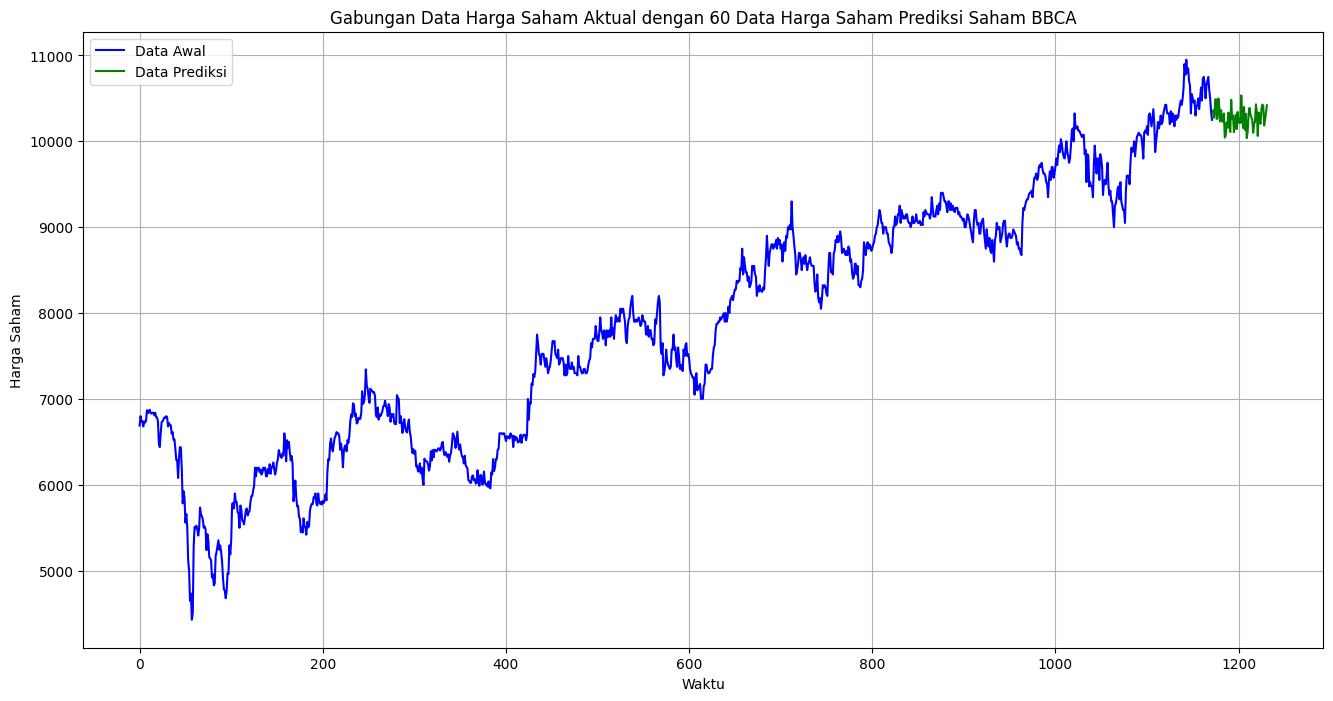

In [30]:
# ==============================================================================
# SEL 16: Visualisasi Gabungan Data Aktual & Prediksi Masa Depan
# ==============================================================================

future_df['Day'] = range(len(df), len(df) + 60)
# Gabungan data sebelumnya dengan prediksi masa depan
combined_df = pd.concat([
    pd.DataFrame({'Day': range(len(df)), 'Close': df['Close']}),
    future_df.rename(columns={'Future Predictions': 'Close'})
], ignore_index=True)

plt.figure(figsize=(16, 8))
plt.plot(combined_df['Day'][:len(df)], combined_df['Close'][:len(df)], label='Data Awal', color='blue')
plt.plot(combined_df['Day'][len(df):], combined_df['Close'][len(df):], label='Data Prediksi', color='green') #, marker='o')
plt.title(f'Gabungan Data Harga Saham Aktual dengan 60 Data Harga Saham Prediksi Saham {stock_name}')
plt.xlabel('Waktu')
plt.ylabel('Harga Saham')
plt.legend()
plt.grid(True)
plt.show()

In [31]:
# ==============================================================================
# Menyimpan Prediksi Masa Depan
# ==============================================================================

# Simpan prediksi masa depan ke DataFrame
future_df.to_excel('future_predictions.xlsx', index=False)
print("\nPrediksi 60 Data ke Depan disimpan ke 'future_predictions.xlsx'")


Prediksi 60 Data ke Depan disimpan ke 'future_predictions.xlsx'


In [37]:
# ==============================================================================
# Visualisasi Return Harian
# ==============================================================================

print("\n=== Visualisasi Return Harian ===")
# Hitung return harian (dalam persen)
df['Return Harian'] = df['Close'].pct_change()
# Hapus nilai NaN pertama (karena tidak ada return untuk hari pertama)
df.dropna(inplace=True)

# Plot return saham dengan label berbahasa Indonesia
fig = px.line(
    df,
    x=df.index,
    y='Return Harian',
    title=f'Grafik <i>Return</i> Harian Saham {stock_name}',
    labels={
        'Date': 'Tanggal',
        'Return Harian': 'Return Harian'
    }
)

# Tambahkan pengaturan layout
fig.update_layout(
    xaxis_title='Tanggal',
    yaxis_title='<i>Return</i> Harian',
    plot_bgcolor='white',
    font_size=15,
    title_x=0.5,
    font_family='Times New Roman',
    xaxis=dict(showline=True,linecolor='black', showgrid=True,              # Menampilkan garis bantu X
        gridcolor='lightgray'),
    yaxis=dict(showline=True,linecolor='black', showgrid=True,              # Menampilkan garis bantu X
        gridcolor='lightgray')
)

fig.show()


=== Visualisasi Return Harian ===
